In [ ]:
###################################################
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time
from astropy.coordinates import SkyCoord
import astropy.units as u
import pyccl as ccl
import clevar
import numpy as np
from astropy.table import Table
import clmm
from clevar.catalog import ClCatalog, MemCatalog
from clevar.match_metrics import recovery
import matplotlib.pyplot as plt
from clevar.match import MembershipMatch
from clevar.match_metrics import distances
from clevar.match_metrics import scaling
from clevar.match import ProximityMatch
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
import pandas
import numpy as np
import pandas as pd
import GCRCatalogs
from crow import mass_proxy
import pyarrow.parquet as pq
import pyarrow as pa

from astropy.table import Table

In [71]:


# Read the FITS file into a table
catalog = Table.read("/sps/lsst/users/maguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

# ----------------------------
# Murata model
# ----------------------------
m_pivot = 14.3
z_pivot = 0.5

mass_richness = mass_proxy.MurataUnbinned(m_pivot, z_pivot)

mass_richness.parameters["mu0"] = 3.2
mass_richness.parameters["mu1"] = 0.8
mass_richness.parameters["mu2"] = 0.1

mass_richness.parameters["sigma0"] = 0.5
mass_richness.parameters["sigma1"] = 0.01
mass_richness.parameters["sigma2"] = 0.02

rng = np.random.default_rng()
display(catalog)
# ----------------------------
# Output parquet writer
# ----------------------------
output_file = "./cosmodc2_with_richness.parquet"
    
redshift = catalog["redshift_true"]
halo_mass = catalog["m200c"]
log10_mass = np.log10(halo_mass)

mu_ln = mass_richness.get_ln_mass_proxy_mean(log10_mass, redshift)
sigma_ln = mass_richness.get_ln_mass_proxy_sigma(log10_mass, redshift)
ln_richness = rng.normal(mu_ln, sigma_ln)

df = pd.DataFrame(
    {
        "redshift": np.array(redshift, dtype=float),
        "halo_mass": np.array(halo_mass, dtype=float),
        "log10_halo_mass": np.array(log10_mass, dtype=float),
        "richness": np.array(np.exp(ln_richness), dtype=float),
    }
)

table = pa.Table.from_pandas(df, preserve_index=False)

writer = pq.ParquetWriter(output_file, table.schema)

writer.write_table(table)

writer.close()
display(df)
print(f"Saved richness catalog to {output_file}")

halo_id,ra_true,dec_true,ra,dec,redshift_true,mass_fof,m200c,r200c,skysim_halo_id,NMEM,richness,NMEM_g_star2,NMEM_r_star2,NMEM_i_star2,NMEM_z_star2,NMEM_y_star2,richness_g_star2,richness_r_star2,richness_i_star2,richness_z_star2,richness_y_star2,ra_bary,dec_bary
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
1600020475,50.77596621112012,-27.11267297840223,50.775875822529436,-27.112584328955446,0.04530489444732666,2.247e+13,18901145086557.746,0.5539122181878964,4308786475,14,8.259415690053675,4,2,2,2,2,3.3159297517335684,2.0,2.0,2.0,2.0,50.86080257640612,-27.111068884566034
2700020475,49.46685631106464,-25.960657456295777,49.466814189348334,-25.960541211222015,0.04615640640258789,1.633e+13,15062094204754.93,0.5136732064502341,5608786475,14,7.310438276043445,7,5,5,5,5,3.9505018568471444,3.162710828265532,3.162710828265532,3.162710828265532,3.162710828265532,49.430749682006216,-26.004253136511434
17200020453,50.16400668612118,-25.25905307744378,50.16585579512233,-25.259404686564693,0.08653247356414795,2.283e+13,20441971397588.734,0.5883426733419929,9508786453,12,5.623277102797734,5,5,5,4,4,3.3387389360236903,3.3387389360236903,3.3387389360236903,3.130245439035445,3.130245439035445,50.10887874151731,-25.222612608640762
19000020453,49.51595503782168,-26.130631687629403,49.51865674267036,-26.131426039026245,0.09413313865661621,1.199e+13,10668658238016.902,0.47378993370163613,29908786453,15,6.997234500189672,7,7,7,7,7,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,49.526283728873516,-26.143323644925193
19800020453,50.68971804154461,-26.886508987581664,50.691634217578326,-26.88681304144144,0.08739697933197021,8.412e+13,71624983358738.03,0.8935768839339135,10408786453,25,10.377440167337566,12,11,9,8,8,5.102184303491505,4.807846043434688,4.353673518160678,4.0503547588246684,4.0503547588246684,50.71067924047927,-26.883765517046655
32800020453,51.49229315287324,-26.308837160731073,51.49405530538187,-26.309071814426567,0.08795535564422607,1.328e+13,10371945197971.832,0.4693405728944591,14908786453,7,4.078294904689155,2,2,2,2,2,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,51.53207787114288,-26.281769096943737
2000020442,51.02799219278836,-25.768148487504888,51.03054382968504,-25.767733992572435,0.10751283168792725,3.555e+13,31256384653340.848,0.6889763852240335,9408786442,22,9.068648511775608,3,3,3,3,2,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.5330209172234177,51.04052597864433,-25.76994686512187
32300020442,51.47772552281113,-25.82579874206229,51.48013416475692,-25.825311694587846,0.10751473903656006,1.339e+13,11587427913554.93,0.49502278717470843,43208786442,10,5.4538674639470575,5,4,4,3,3,3.6826146155436636,2.6826146155436636,2.6826146155436636,2.0956992167416817,2.0956992167416817,51.46172414586285,-25.805957090122217
33300020442,50.31241043560731,-26.69591460405023,50.315518939516316,-26.69559169836869,0.108817458152771,3.434e+13,29876928281239.438,0.6786574780101507,44708786442,16,6.788349932828027,8,8,8,8,8,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,50.28802465790821,-26.712593565283026


,redshift,halo_mass,log10_halo_mass,richness
0,0.045305,1.890115e+13,13.276488,2.742424
1,0.046156,1.506209e+13,13.177885,4.577887
2,0.086532,2.044197e+13,13.310523,1.807625
3,0.094133,1.066866e+13,13.028110,2.283147
4,0.087397,7.162498e+13,13.855065,19.883987
...,...,...,...,...
454470,3.027283,1.039016e+13,13.016622,7.325576
454471,3.031686,1.009866e+13,13.004264,2.370032
454472,3.014547,1.138702e+13,13.056410,2.637253
454473,2.950915,1.233962e+13,13.091302,1.416692


Saved richness catalog to ./cosmodc2_with_richness.parquet


In [40]:

###################################################

# Imports Catalog and creats a table (t_cl) containing Mass ('M'), redshift ('redshift_true') and richness ('NMEM')


#t_halo = Table.read("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_halo_cluster_catalog.fits")
#t_cl = Table.read("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_halo_cluster_catalog.fits")
t_halo = pandas.read_parquet("./cosmodc2_with_richness.parquet")
t_halo=t_halo[t_halo['log10_halo_mass'] >= 14.3]
t_cluster = pandas.read_parquet("./cosmodc2_with_richness.parquet")
Mp, zp = 10**14.3, 0.5
display(Table.read("/sps/lsst/users/maguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits"))


cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)
display(t_halo["richness"])


halo_id,ra_true,dec_true,ra,dec,redshift_true,mass_fof,m200c,r200c,skysim_halo_id,NMEM,richness,NMEM_g_star2,NMEM_r_star2,NMEM_i_star2,NMEM_z_star2,NMEM_y_star2,richness_g_star2,richness_r_star2,richness_i_star2,richness_z_star2,richness_y_star2,ra_bary,dec_bary
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
1600020475,50.77596621112012,-27.11267297840223,50.775875822529436,-27.112584328955446,0.04530489444732666,2.247e+13,18901145086557.746,0.5539122181878964,4308786475,14,8.259415690053675,4,2,2,2,2,3.3159297517335684,2.0,2.0,2.0,2.0,50.86080257640612,-27.111068884566034
2700020475,49.46685631106464,-25.960657456295777,49.466814189348334,-25.960541211222015,0.04615640640258789,1.633e+13,15062094204754.93,0.5136732064502341,5608786475,14,7.310438276043445,7,5,5,5,5,3.9505018568471444,3.162710828265532,3.162710828265532,3.162710828265532,3.162710828265532,49.430749682006216,-26.004253136511434
17200020453,50.16400668612118,-25.25905307744378,50.16585579512233,-25.259404686564693,0.08653247356414795,2.283e+13,20441971397588.734,0.5883426733419929,9508786453,12,5.623277102797734,5,5,5,4,4,3.3387389360236903,3.3387389360236903,3.3387389360236903,3.130245439035445,3.130245439035445,50.10887874151731,-25.222612608640762
19000020453,49.51595503782168,-26.130631687629403,49.51865674267036,-26.131426039026245,0.09413313865661621,1.199e+13,10668658238016.902,0.47378993370163613,29908786453,15,6.997234500189672,7,7,7,7,7,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,49.526283728873516,-26.143323644925193
19800020453,50.68971804154461,-26.886508987581664,50.691634217578326,-26.88681304144144,0.08739697933197021,8.412e+13,71624983358738.03,0.8935768839339135,10408786453,25,10.377440167337566,12,11,9,8,8,5.102184303491505,4.807846043434688,4.353673518160678,4.0503547588246684,4.0503547588246684,50.71067924047927,-26.883765517046655
32800020453,51.49229315287324,-26.308837160731073,51.49405530538187,-26.309071814426567,0.08795535564422607,1.328e+13,10371945197971.832,0.4693405728944591,14908786453,7,4.078294904689155,2,2,2,2,2,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,51.53207787114288,-26.281769096943737
2000020442,51.02799219278836,-25.768148487504888,51.03054382968504,-25.767733992572435,0.10751283168792725,3.555e+13,31256384653340.848,0.6889763852240335,9408786442,22,9.068648511775608,3,3,3,3,2,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.5330209172234177,51.04052597864433,-25.76994686512187
32300020442,51.47772552281113,-25.82579874206229,51.48013416475692,-25.825311694587846,0.10751473903656006,1.339e+13,11587427913554.93,0.49502278717470843,43208786442,10,5.4538674639470575,5,4,4,3,3,3.6826146155436636,2.6826146155436636,2.6826146155436636,2.0956992167416817,2.0956992167416817,51.46172414586285,-25.805957090122217
33300020442,50.31241043560731,-26.69591460405023,50.315518939516316,-26.69559169836869,0.108817458152771,3.434e+13,29876928281239.438,0.6786574780101507,44708786442,16,6.788349932828027,8,8,8,8,8,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,50.28802465790821,-26.712593565283026


205       32.879897
266       15.446110
356       14.839566
616       31.935156
645       22.580819
            ...    
451991    69.400982
452057    27.837547
452573    20.897128
452808    81.480624
453668    38.428241
Name: richness, Length: 1326, dtype: float64

## Mass-Richness

In [56]:
def prior(params):
    if len(params) == 6:
        A, B, C, D, E, F = params
        if -2<C<2 and -2<E<2 and -2<F<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
    else:
        A, B, D, E = params
        if -2<E<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
def _ln_L(params, X, a, b, use_correction):
    # 1. Prior Check
    if not prior(params):
        return -np.inf
    
    # 2. Extract Data & Params
    pop, M, z = np.log(X["richness"]), X["halo_mass"], X["redshift"]
    
    if len(params) == 6:
        A, B, C, D, E, F = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    else:
        A, B, D, E = params
        mean_alpha = A + B*np.log(M/Mp)
        sigma = D + E*np.log(M/Mp)
    
    # 3. Physicality Check (Sigma must be positive for all points)
    if np.any(sigma <= 0):
        return -np.inf
    
    # 4. Standard Log-likelihood calculation
    # Using np.sum for speed and stability
    term1 = -0.5 * np.log(2 * np.pi * sigma**2)
    term2 = -0.5 * ((pop - mean_alpha) / sigma)**2
    ln_L = np.sum(term1 + term2)
    
    # 5. Optional Truncation Correction (Corrected logic)
    if use_correction:
        # P(a < NMEM < b) = 0.5 * [erf((log(b)-mu)/(sig*sqrt2)) - erf((log(a)-mu)/(sig*sqrt2))]
        inv_sig_root2 = 1.0 / (sigma * np.sqrt(2))
        def erf_func(val):
            return scipy.special.erf((np.log(val) - mean_alpha) * inv_sig_root2)
        
        prob_in_bin = 0.5 * (erf_func(b) - erf_func(a))
        # Add the log of the normalization to the total likelihood
        ln_L -= np.sum(np.log(np.clip(prob_in_bin, 1e-10, None)))
        
    return ln_L

def MCMC(richesse_bin, redshift_bin, itt, redshift_params=True, correction=True):
    a, b = richesse_bin
    c, d = redshift_bin
    
    # Selection
    mask = (t_halo["richness"] > a) & (t_halo["richness"] < b) & \
           (t_halo["redshift"] > c) & (t_halo["redshift"] < d) 
            
    X = t_halo[mask]
    display(X)
    if len(X) < 10: # Safety check for empty bins
        print(f"Warning: Bin {richesse_bin}, {redshift_bin} has only {len(X)} clusters.")
        return {'mean': np.zeros(6 if redshift_params else 4), 'std': np.zeros(6 if redshift_params else 4)}

    ndim = 6 if redshift_params else 4
    nwalkers = 48 # Use a multiple of 2 or 4 for better threading
    
    # Better initialization
    if redshift_params:
        guess = np.array([3.2, 0.8, 0.1, 0.5, 0.01, 0.01])
    else:
        guess = np.array([3.2, 0.8, 0.5, 0.01])
        
    p0 = [guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b, correction])
    sampler.run_mcmc(p0, itt, progress=True)
    
    # Correct result extraction (Flattening)
    burn_in = int(itt * 0.3)
    unflat_samples = sampler.get_chain(discard=burn_in, flat=False)
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)    
    return {
        'chains': unflat_samples,
        'mean': np.mean(flat_samples, axis=0),
        'median': np.median(flat_samples, axis=0),
        'std': np.std(flat_samples, axis=0)
    }

In [57]:
### Unbinned relation

,redshift,halo_mass,log10_halo_mass,richness
205,0.467930,2.551733e+14,14.406835,32.879897
616,0.721966,2.049455e+14,14.311638,31.935156
645,0.777342,2.062885e+14,14.314475,22.580819
669,0.765375,2.595980e+14,14.414301,21.479928
769,0.794393,2.730932e+14,14.436311,40.488889
...,...,...,...,...
448255,0.640042,3.379458e+14,14.528847,32.245563
448383,0.707495,3.186803e+14,14.503355,24.580606
451225,0.428835,6.841658e+14,14.835161,77.038189
451991,0.810806,5.004717e+14,14.699380,69.400982


100%|██████████| 2000/2000 [01:28<00:00, 22.54it/s]


{'chains': array([[[ 3.16254475e+00,  8.77528531e-01, -1.60852848e-01,
          5.51026077e-01, -3.74429179e-02, -7.95035138e-02],
        [ 3.16387588e+00,  8.20042052e-01, -3.82887275e-01,
          5.08056752e-01, -1.14233306e-02, -5.11279935e-02],
        [ 3.07327337e+00,  8.61081626e-01,  5.73988620e-01,
          5.62433072e-01,  5.34908782e-02, -5.17717349e-01],
        ...,
        [ 3.01288368e+00,  9.81115602e-01,  5.60930810e-01,
          5.41901795e-01,  6.21011639e-02, -3.55978971e-01],
        [ 3.01116303e+00,  9.55179837e-01, -9.61021886e-02,
          5.59923220e-01, -6.90407667e-03, -8.01925305e-02],
        [ 3.03775390e+00,  9.22655278e-01, -1.79627734e-03,
          5.96591658e-01, -9.98110083e-02,  2.92884232e-02]],

       [[ 3.16405465e+00,  8.75541251e-01, -1.53814728e-01,
          5.38663813e-01, -1.89358249e-02, -6.63999828e-02],
        [ 3.13687430e+00,  8.61252507e-01, -2.38427544e-01,
          5.19579970e-01, -1.22596467e-02, -1.00737420e-01],
      

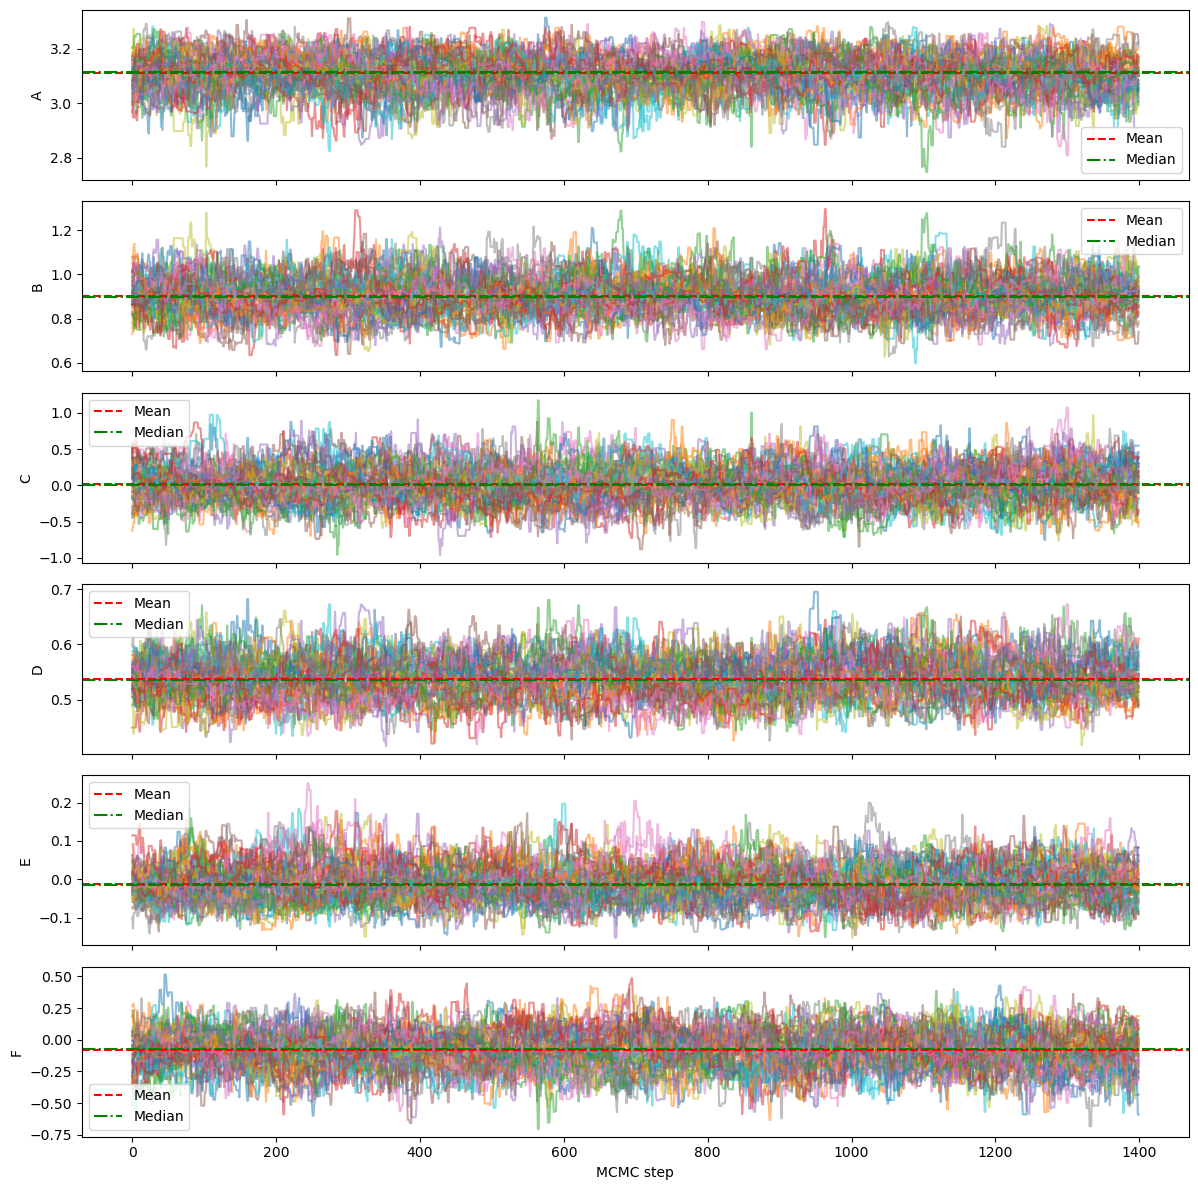

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------------------------
# Assuming you run MCMC once for all clusters (global), returns 6 parameters
# ------------------------------------------------------------------------------

# Run your MCMC once
res = MCMC(richesse_bin=(20,200), 
          redshift_bin=(0.2,1.0), 
          itt=2000, redshift_params=True, correction=True)
print(res)
# Extract chains and statistics
chains = res['chains']  # shape: (nsteps, nwalkers, 6) or similar
means = res['mean']     # length 6
stds  = res['std']      # length 6
medians = res['median']
# Print best-fit values
param_names = ['A','B','C','D','E','F']
for i, name in enumerate(param_names):
    print(f"{name}: mean={means[i]:.4f}, std={stds[i]:.4f}")
    print(f"{name}: median={medians[i]:.4f}, std={stds[i]:.4f}")

# ------------------------------------------------------------------------------
# Plot chains to check convergence
# ------------------------------------------------------------------------------
n_params = 6
nsteps, nwalkers = chains.shape[0], chains.shape[1]

fig, axes = plt.subplots(n_params, 1, figsize=(12, 2*n_params), sharex=True)
for i in range(n_params):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(chains[:, w, i], alpha=0.5)
    # Show mean and median lines
    mean_i = np.mean(chains[:, :, i])
    median_i = np.median(chains[:, :, i])
    ax.axhline(mean_i, color='red', linestyle='--', label='Mean')
    ax.axhline(median_i, color='green', linestyle='-.', label='Median')
    ax.set_ylabel(param_names[i])
    ax.legend()
axes[-1].set_xlabel('MCMC step')
plt.tight_layout()
plt.show()


In [ ]:
## Save to sacc

In [77]:
import math
import itertools

import numpy as np

from numcosmo_py import Nc
from numcosmo_py import Ncm

from astropy.table import Table

from astropy.io import fits
from scipy import stats
from typing import Any
import sacc

data_table = t_cluster
data_table = data_table[data_table['redshift'] >= 0.2]
data_table = data_table[data_table['redshift'] <= 1.0]
data_table = data_table[data_table['richness'] >= 20]
data_table = data_table[data_table['richness'] <= 200]


area = 439.78986

cluster_z = data_table["redshift"]
cluster_richness = np.log10(data_table["richness"])

bins_rich = np.log10([20,35,70,200])
bins_z = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    cluster_z, cluster_richness, None, "count", bins=[bins_z, bins_rich]
)
print(cluster_counts)
print(np.sum(cluster_counts))
covariance = np.diag(cluster_counts.flatten())
print(np.mean(cluster_z), np.min(cluster_z))
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "cosmodc2_halos"
s_count.add_tracer("survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    lower, upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, lower, upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    lower, upper = richness_bin
    bin_richness_label = f"rich_{i}"
    s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
    bin_richness_labels.append(bin_richness_label)

#  pylint: disable-next=no-member
cluster_count = sacc.standard_types.cluster_counts

counts_and_edges = zip(
    cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)


for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_richness_label, bin_z_label), int(counts)
    )
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("./outputs_mor/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./outputs_cosmo/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./outputs_both/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./clusters_sacc_file.sacc", overwrite=True)


[[469. 128.  31.]
 [712. 223.  27.]
 [904. 263.  34.]
 [893. 218.  24.]]
3926.0
0.6481568993686476 0.20034563541412354


In [75]:
import numpy as np
import pandas as pd
import GCRCatalogs
from crow import mass_proxy
from crow import ClusterAbundance
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
from astropy.table import Table
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.interpolate import interp1d

from crow import ClusterShearProfile
from crow import ClusterAbundance
from crow.recipes.binned_exact import ExactBinnedClusterRecipe
from crow.recipes.binned_grid import GridBinnedClusterRecipe
from crow import completeness_models, mass_proxy, purity_models, kernel
from crow.properties import ClusterProperty

# ---- Core cosmology and HMF (same numbers as your example) ----
hmf = ccl.halos.MassFuncTinker08(mass_def="200c")

cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)



cl_abundandce = ClusterAbundance(cosmo, hmf)
m_pivot = 14.3
z_pivot = 0.5
z_bins = [(z_edges[i], z_edges[i+1]) for i in range(len(z_edges) -1)]
proxy_bins = [(richness_edges[i], richness_edges[i+1]) for i in range(len(richness_edges) - 1)]
redshift_distribution = kernel.SpectroscopicRedshift()


print(z_edges, richness_edges)
# ---- Common grid / binning parameters for later cells ----
mass_grid_size = 80
redshift_grid_size = 40
proxy_grid_size = 40
sky_area = 440
mass_interval = (12.5, 17.0)


cl_abundandce = ClusterAbundance(cosmo, hmf)

recipe_grid_nocomp = GridBinnedClusterRecipe(
    mass_interval=mass_interval,
    cluster_theory=cl_abundandce,
    redshift_distribution=redshift_distribution,
    mass_distribution=mass_richness,
    proxy_grid_size=proxy_grid_size,
    redshift_grid_size=redshift_grid_size,
    mass_grid_size=mass_grid_size,
)
recipe_grid_nocomp.setup()


exact_t0 = time.time()
grid_nocomp_vals  = np.zeros((len(z_edges) -1,len(richness_edges) - 1))

for i, zb in enumerate(z_bins):
    for j, pb in enumerate(proxy_bins):
        grid_nocomp_vals[i,j]  = recipe_grid_nocomp.evaluate_theory_prediction_counts(np.array(zb), np.array(pb), sky_area)

print(cluster_counts, grid_nocomp_vals)
print(1.0 - cluster_counts / grid_nocomp_vals)

[0.2 0.4 0.6 0.8 1. ] [1.30103    1.54406804 1.84509804 2.30103   ]
[[469. 128.  31.]
 [712. 223.  27.]
 [904. 263.  34.]
 [893. 218.  24.]] [[406.38793069 131.56720179  22.03213799]
 [732.34240253 216.36925652  31.4908764 ]
 [865.05890439 229.54614999  28.42048604]
 [805.94262384 189.75361213  19.69195001]]
[[-0.15406971  0.02711315 -0.40703549]
 [ 0.02777717 -0.0306455   0.14260881]
 [-0.04501554 -0.1457391  -0.19632015]
 [-0.10801932 -0.14885824 -0.21877214]]


In [ ]:
print(grid_nocomp_vals)